In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt

#loading data
file_1="../Dataset/B0005_dis_dataset.csv"
file_2="../Dataset/B0006_dis_dataset.csv"
dataset_1=pd.read_csv(file_1)
dataset_2=pd.read_csv(file_2)

C_max=2.05

#renaming columns for simplicity
dataset_1.columns=['cycle',"capacity",'voltage', 'current','temperature', 'current_load', 'voltage_load',"time"]
dataset_1["current_load"]= abs(dataset_1["current_load"])

#removing ideling / starting and ending current level data  
df_1=dataset_1[(dataset_1.current_load>=0.006)].reset_index(drop=True)

# converting time seconds->hour
df_1["time"]=df_1["time"]/3600

#calculate Soc for each cycle
cycle_count=df_1["cycle"].unique()
Soc_list=[]

# Update Soc for each reading within each cycle using Coulomb counting
for cycle in cycle_count:
    cycle_data = df_1[df_1['cycle'] == cycle]
    
    cumulative_Soc = [sum(cycle_data["capacity"])/len(cycle_data["capacity"])]
    
    for i in range(1, len(cycle_data)):
        
        delta_time = cycle_data['time'].iloc[i-1] - cycle_data['time'].iloc[i]
        
        delta_charge = cycle_data['current'].iloc[i] * delta_time
        
        cumulative_Soc.append(cumulative_Soc[-1] -delta_charge)
        
    Soc_list.extend(cumulative_Soc)

#DOD is the opposite of the soc 
df_1["Soc"] = [(q / C_max) for q in Soc_list]
df_1["Soh"]=df_1["capacity"]/C_max



#renaming columns for simplicity
dataset_2.columns=['cycle',"capacity",'voltage', 'current','temperature', 'current_load', 'voltage_load',"time"]
dataset_2["current_load"]= abs(dataset_2["current_load"])

#removing ideling / starting and ending current level data  
df_2=dataset_2[(dataset_2.current_load>=0.006)].reset_index(drop=True)

# converting time seconds->hour
df_2["time"]=df_2["time"]/3600

#calculate Soc for each cycle
cycle_count=df_2["cycle"].unique()
Soc_list=[]

# Update Soc for each reading within each cycle using Coulomb counting
for cycle in cycle_count:
    cycle_data = df_2[df_2['cycle'] == cycle]
    
    cumulative_Soc = [sum(cycle_data["capacity"])/len(cycle_data["capacity"])]
    
    for i in range(1, len(cycle_data)):
        
        delta_time = cycle_data['time'].iloc[i-1] - cycle_data['time'].iloc[i]
        
        delta_charge = cycle_data['current'].iloc[i] * delta_time
        
        cumulative_Soc.append(cumulative_Soc[-1] -delta_charge)
        
    Soc_list.extend(cumulative_Soc)

#DOD is the opposite of the soc 
df_2["Soc"] = [(q / C_max) for q in Soc_list]
df_2["Soh"]=df_2["capacity"]/C_max



In [6]:
cor_1 = df_1.corr()
cor_2 =df_2.corr()

<Axes: >

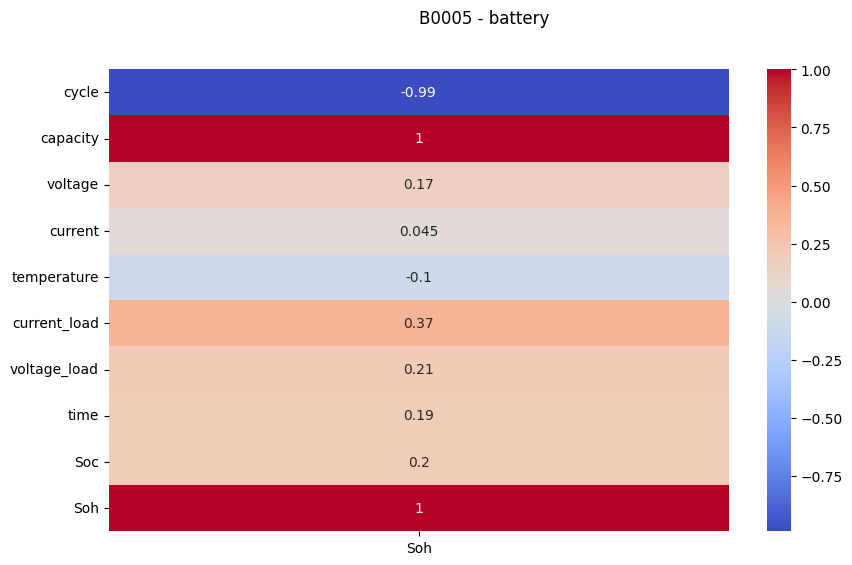

In [9]:
plt.figure(figsize=(10,6))  #select value out of range(0.05,-0.05)
plt.suptitle("B0005 - battery")
sns.heatmap(cor_1[["Soh"]],annot=True,cmap='coolwarm')

#cycle,current_load

<Axes: >

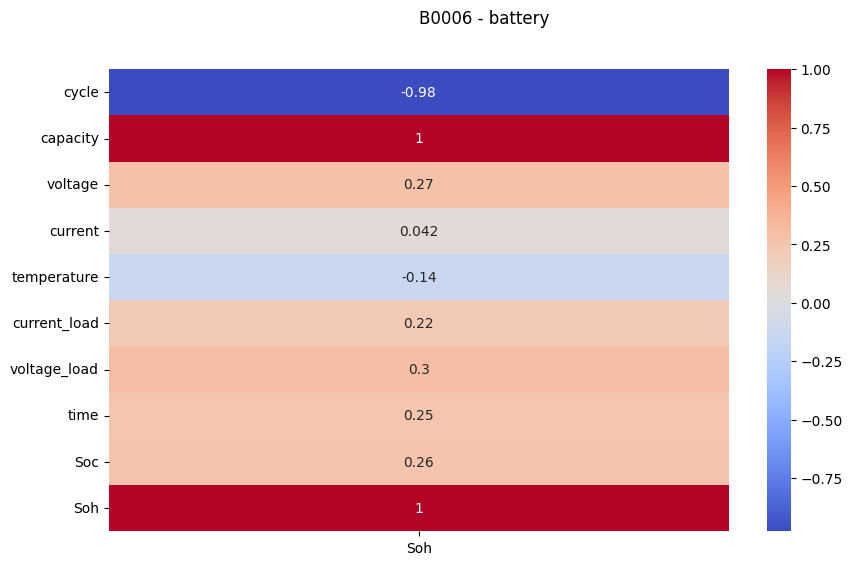

In [10]:
plt.figure(figsize=(10,6))  #select value out of range(0.05,-0.05)
plt.suptitle("B0006 - battery")
sns.heatmap(cor_2[["Soh"]],annot=True,cmap='coolwarm')
#cycle,current_load